Here we apply a CG-twogrid solver with weighted Jacobi smoothing to the linear system that arises from the discretization of
\begin{align*}
-\Delta u&=f\quad\text{ in }\Omega \\
u &= 0\quad \text{ on }\Gamma_{D} \\
\frac{\partial u}{\partial n}&=0\quad \text{ on }\Gamma_{N}
\end{align*}

where $\Gamma_{N}\cup\Gamma_{D}=\partial\Omega$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSparse import interior_pt
from hippylib import nb

from helperfunctions import *

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

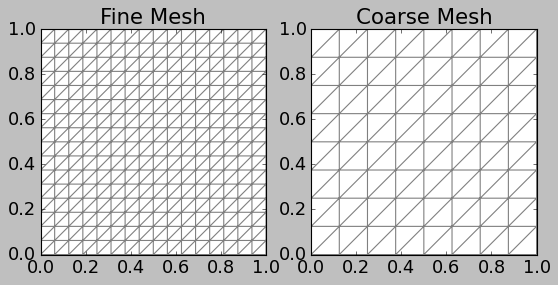

In [3]:
nx_coarse = 8 
nx = 16

# coarse and fine meshes
mesh_coarse = dl.UnitSquareMesh(nx_coarse, nx_coarse)

mesh_fine   = dl.UnitSquareMesh(nx, nx)

meshes = [mesh_coarse, mesh_fine]
mesh   = meshes[-1]
lvl    = len(meshes) # depth of mesh hierarchy
plt.subplot(1,2,1)
dl.plot(mesh)
plt.title('Fine Mesh')
plt.subplot(1,2,2)
dl.plot(mesh_coarse)
plt.title('Coarse Mesh')
plt.show()


In [4]:
P1s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), 1) for i in range(lvl)]
Vh1s = [dl.FunctionSpace(meshes[i], P1s[i]) for i in range(lvl)]

In [5]:
class Boundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return (dl.near(x[0], 0.0) or dl.near(x[0], 1.0)) and on_boundary

As = [None for i in range(lvl)]
Ss = [None for i in range(lvl)]
bs = [None for i in range(lvl)]
for i, Vh1 in enumerate(Vh1s):
    test  = dl.TestFunction(Vh1)
    trial = dl.TrialFunction(Vh1)
    aform = dl.inner(dl.grad(test),dl.grad(trial))*dl.dx(Vh1.mesh())
    Lform = dl.Constant(1.0)*test*dl.dx(Vh1.mesh())
    bc    = dl.DirichletBC(Vh1, dl.Constant(0.0), Boundary())
    As[i], bs[i] = dl.assemble_system(aform, Lform, bc)
    As[i] = csr_fenics2scipy(As[i])
    bs[i] = bs[i][:]
    Ss[i] = sps.diags(0.66/As[i].diagonal())    

In [6]:
P = csr_fenics2scipy(\
         dl.PETScDMCollection.create_transfer_matrix(\
         Vh1s[0], Vh1s[1]))
R = P.transpose()

In [7]:
smoothing_steps = 1
two_grid_P = two_grid_action(As[1], As[0], Ss[1], P, R, smoothing_steps)

krylov_convergence = Krylov_convergence(As[1], bs[1])
krylov_convergence.reset()
lintol=1.e-12
maxiter=50



u, info = spla.cg(As[1], bs[1], tol=lintol, atol=lintol, \
                   M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
print("final residual = {0:1.2e} (two-grid with coarse grid correction) \n".format(np.linalg.norm(As[1].dot(u)-bs[1])))
residuals_twogrid = np.array(krylov_convergence.residuals).copy()
if len(residuals_twogrid)==maxiter:
    print("two-grid preconditioner scheme did not converge in {0:d} iterations\n".format(maxiter))
else:
    print("two-grid preconditioner scheme did converge in {0:d} iterations\n".format(len(residuals_twogrid)))

    
    
krylov_convergence.reset()

u, info = spla.cg(As[1], bs[1], tol=lintol, atol=lintol, \
                   maxiter=maxiter, callback=krylov_convergence.callback)
print("final residual = {0:1.2e} (two-grid with no preconditioner)\n".format(np.linalg.norm(As[1].dot(u)-bs[1])))
residuals_noP = np.array(krylov_convergence.residuals).copy()


if len(residuals_noP)==maxiter:
    print("no preconditioner scheme did not converge in {0:d} iterations\n".format(maxiter))
else:
    print("no preconditioner scheme did converge in {0:d} iterations\n".format(len(residuals_noP)))

final residual = 9.12e-13 (two-grid with coarse grid correction) 

two-grid preconditioner scheme did converge in 14 iterations

final residual = 7.67e-13 (two-grid with no preconditioner)

no preconditioner scheme did converge in 48 iterations



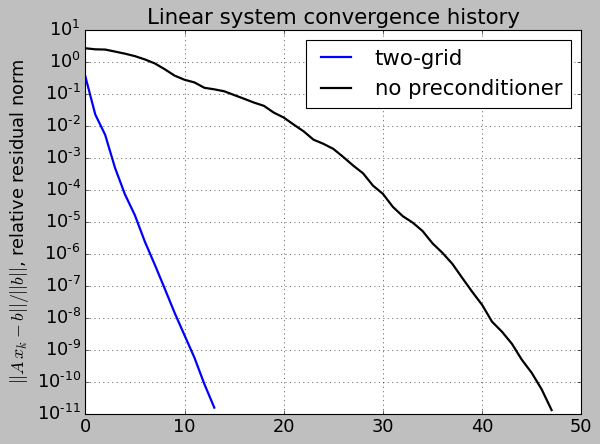

In [8]:
plt.plot(residuals_twogrid, label='two-grid', linewidth=2.0)
plt.plot(residuals_noP, 'k', label='no preconditioner', linewidth=2.0)
plt.yscale('log')
plt.ylabel(r'$||A\,x_{k}-b||/||b||$, relative residual norm')
plt.title('Linear system convergence history')
plt.legend()
plt.grid()
plt.show()

In [9]:
ei = np.zeros(two_grid_P.shape[0])
PA = np.zeros(two_grid_P.shape)

for i in range(two_grid_P.shape[0]):
    ei[i] = 1.0
    PA[:,i] = two_grid_P._matvec(As[1].dot(ei))
    ei[i] = 0.0
condPA = np.linalg.cond(PA)
print("condition number of preconditioned system matrix = {0:1.3e}".format(condPA))
print("condition number of system matrix = {0:1.3e}".format(np.linalg.cond(As[1].todense())))

condition number of preconditioned system matrix = 2.194e+00
condition number of system matrix = 2.198e+02
